In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import spinmob as sm
import mcphysics as mphys
from scipy.optimize import curve_fit

11


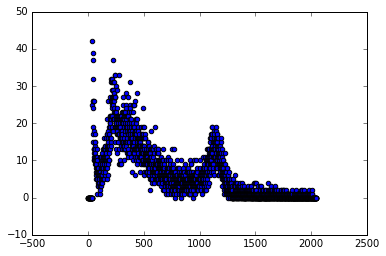

In [37]:
#Gaussian, where m=peak, o=variance, A=amplitude, B=Linear Coeff., C=Linear Offset
def Gaussian(x, m, o, A, B, C):
    return A*np.exp(-0.5*(((x-m)/o)**2)) + B*x + C

#Curve fits a Gaussian to a given emitter's callibration data curve. The interval determines the width of data
#which the Gaussian fits around. 
def Fit(input_databox, interval, guess):
    xData = np.arange(0, 2048)
    param, cov = curve_fit(Gaussian, xData[guess-interval:guess+interval], 
                           input_databox[guess-interval:guess+interval], p0=[guess, 10, 10, 10, 10])
    error = np.sqrt(np.diag(cov))
    print(param), print(error)
    return [param, error]

def Chi()

## Angle 125 - Aluminum


[ 1.14072238e+03  5.57108128e+01  1.06217939e+01 -9.16006797e-03
  1.32792538e+01]
[2.11582313e+00 2.60076018e+00 3.54153056e-01 1.25901504e-03
 1.38333286e+00]


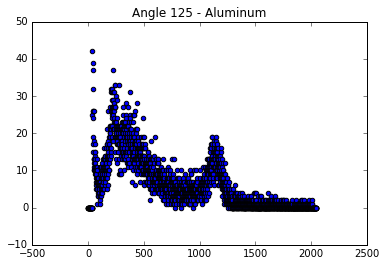

In [40]:
data = mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 027.Chn')[1]
data += mphys.data.load_chn('Compton/Angles/125/02 Aluminum/02 Aluminum 125 degrees 036.Chn')[1]

plt.scatter(np.arange(0, 2048), data)
plt.title('Angle 125 - Aluminum')

Al_125param = Fit(data, 200, 1125)